<a href="https://colab.research.google.com/github/rikurzt/Finacial_analyze_course_HW/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A_HW8%269_7113029027%E6%9D%8E%E5%86%A0%E5%BB%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 匯入資料

In [ ]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt


In [ ]:
def call_twse_api(stock_id=2330, year=2024, month=9):
  """Calls the TWSE API to retrieve stock data for a specific month."""
  url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={year}{month:02}01&stockNo={stock_id}"
  try:
    response = requests.get(url)
    response.raise_for_status()
    return response.json()
  except requests.exceptions.RequestException as e:
    print(f"Error calling API: {e}")
    return None

In [ ]:
def get_stock_data(stock_id, start_year, end_year):
  """Retrieves stock data for a given stock ID within a year range."""
  all_data = []
  for year in range(start_year, end_year + 1):
    for month in range(1, 13):
      data = call_twse_api(stock_id, year, month)
      if data and 'data' in data:
        all_data.extend(data['data'])
  return all_data

In [ ]:
stock_data = get_stock_data('0050', start_year =2020, end_year = 2023)

df = pd.DataFrame(stock_data, columns=['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數'])


In [ ]:
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,109/01/02,"4,882,015","476,649,683",97.05,98.00,97.05,97.65,+0.70,"2,421"
1,109/01/03,"6,813,547","665,657,992",98.30,98.70,97.00,97.65,0.00,"3,080"
2,109/01/06,"9,321,768","901,060,879",97.05,97.10,96.40,96.40,-1.25,"4,809"
3,109/01/07,"6,328,602","607,425,541",96.45,96.70,95.40,96.10,-0.30,"4,116"
4,109/01/08,"8,516,995","813,733,739",95.20,96.20,95.05,95.65,-0.45,"5,033"
...,...,...,...,...,...,...,...,...,...
969,112/12/25,"8,406,012","1,122,521,003",133.00,133.80,132.95,133.50,+0.55,"8,464"
970,112/12/26,"17,326,648","2,325,240,676",133.50,134.40,133.50,134.25,+0.75,"11,845"
971,112/12/27,"30,857,192","4,177,189,577",134.40,135.90,134.35,135.75,+1.50,"16,671"
972,112/12/28,"15,353,146","2,085,248,437",135.75,136.00,135.45,135.75,0.00,"9,803"


## 計算指標


In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=b94e894a6ed7cc5e96206ad3c6a703ed380de9e344c1b92c0a0611bcccaff805
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:

df['開盤價'] = pd.to_numeric(df['開盤價'])
df['最高價'] = pd.to_numeric(df['最高價'])
df['最低價'] = pd.to_numeric(df['最低價'])
df['收盤價'] = pd.to_numeric(df['收盤價'])


In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta

In [ ]:
def calculate_sma(data, window):

  return ta.sma(data['收盤價'], length=window)

def calculate_rsi(data, window):
  return ta.rsi(data['收盤價'], length=window)

def calculate_macd(data, short_window, long_window, signal_window):
  try:
      macd_df = ta.macd(data['收盤價'], fast=short_window, slow=long_window, signal=signal_window)
      return macd_df['MACD_12_26_9'], macd_df['MACDh_12_26_9'], macd_df['MACDs_12_26_9']
  except (KeyError, TypeError):
    return None, None, None

def calculate_ema(data, window):
  return ta.ema(data['收盤價'], length=window)


In [ ]:

def calculate_kd(df, n=9):

  df['RSV'] = ((df['收盤價'] - df['最低價'].rolling(n).min()) /
              (df['最高價'].rolling(n).max() - df['最低價'].rolling(n).min())) * 100
  df['K'] = 50
  df['D'] = 50

  for i in range(n, len(df)):
      df['K'].iloc[i] = (df['K'].iloc[i - 1] * 2 / 3) + (df['RSV'].iloc[i] * 1 / 3)
      df['D'].iloc[i] = (df['D'].iloc[i - 1] * 2 / 3) + (df['K'].iloc[i] * 1 / 3)



In [ ]:
#cal all metrics
def calculate_all_metrics(df):
  df['SMA_5'] = calculate_sma(df, 5)
  df['SMA_10'] = calculate_sma(df, 10)
  df['SMA_20'] = calculate_sma(df, 20)
  df['RSI_14'] = calculate_rsi(df, 14)
  calculate_kd(df)
  return df
df = calculate_all_metrics(df)

<ipython-input-9-2ac63577080d>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['K'].iloc[i] = (df['K'].iloc[i - 1] * 2 / 3) + (df['RSV'].iloc[i] * 1 / 3)
<ipython-input-9-2ac63577080d>:9: SettingWithCopyWarning: 
A value is trying to be 

In [ ]:
df_ori = df.copy()
df = df.dropna()
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_5,SMA_10,SMA_20,RSI_14,RSV,K,D
19,109/02/07,"9,554,828","871,832,328",91.65,91.65,90.95,91.20,-1.10,"4,992",90.80,92.840,95.0150,34.166273,34.615385,33.154368,31.860886
20,109/02/10,"7,308,908","661,411,947",90.00,91.20,89.60,91.00,-0.20,"3,838",91.19,92.210,94.6825,33.576361,32.692308,33.000348,32.240707
21,109/02/11,"5,115,402","468,988,015",91.35,91.95,91.35,91.75,+0.75,"3,724",91.42,91.655,94.3875,37.906035,56.081081,40.693926,35.058446
22,109/02/12,"5,640,117","521,567,062",92.00,92.90,92.00,92.65,+0.90,"2,845",91.78,91.150,94.2000,42.730220,95.283019,58.890290,43.002394
23,109/02/13,"5,754,317","534,947,681",93.00,93.25,92.70,92.80,+0.15,"2,530",91.88,91.215,94.0350,43.517845,92.035398,69.938660,51.981149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,112/12/25,"8,406,012","1,122,521,003",133.00,133.80,132.95,133.50,+0.55,"8,464",133.24,133.000,132.0125,62.980484,75.000000,70.404319,72.454952
970,112/12/26,"17,326,648","2,325,240,676",133.50,134.40,133.50,134.25,+0.75,"11,845",133.41,133.275,132.1625,66.191808,93.617021,78.141887,74.350597
971,112/12/27,"30,857,192","4,177,189,577",134.40,135.90,134.35,135.75,+1.50,"16,671",133.81,133.695,132.3925,71.514093,96.103896,84.129223,77.610139
972,112/12/28,"15,353,146","2,085,248,437",135.75,136.00,135.45,135.75,0.00,"9,803",134.44,133.955,132.6125,71.514093,93.670886,87.309777,80.843352


# 資料前處理

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#select feature
feature = ['開盤價','最高價','最低價','收盤價','SMA_5','SMA_10','SMA_20','RSI_14','K','D']
target = ['收盤價']

In [ ]:
class MyDataSet(data.Dataset):
  def __init__(self,df,seq_len,train=True,transform=None):#繼承dataset需要transform，Train:使用訓練資料還是測試資料
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    df_len = len(df)-1
    df_len -= df_len%seq_len#根據設定序列長度seq_len，扣掉剩下不足的部分
    total_size = df_len // seq_len#現在總共有多少條序列
    train_size = int(total_size * 0.8) #訓練資料使用70%的序列

    f = df.iloc[:(train_size * seq_len)][feature]
    l = df.iloc[1:(train_size * seq_len)+1][target]#用前一天的資料預測，所以從1開始取
    data_size = train_size
    if not train:#使用者要測試資料的情況
      f = df.iloc[train_size * seq_len:df_len][feature]
      l = df.iloc[(train_size * seq_len)+1:df_len+1][target]
      data_size = total_size - train_size

    self.features = np.array(f).astype("float32").reshape(data_size,seq_len,len(feature))
    self.labels = np.array(l).astype("float32").reshape(data_size,seq_len,1)
    self.transform = transform
  def __len__(self):#取得目前處理的資料長度
    return len(self.labels)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x = self.features[idx]
    y = self.labels[idx]
    if self.transform:
      x = self.transform(x)
      y = self.transform(y)
    return x,y

In [ ]:
def toTensor(x):
  return torch.tensor(x)

In [ ]:
train_dataset = MyDataSet(df,seq_len=5,train=True,transform=toTensor)
test_dataset = MyDataSet(df,seq_len=5,train=False,transform=toTensor)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=5,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=5,shuffle=False)

for i,(seqs,labels) in enumerate(train_loader):
  print(seqs.shape)


torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([5, 5, 10])
torch.Size([2, 5, 10])


In [ ]:
train_loader.dataset.features[-1]

array([[117.95    , 119.1     , 117.4     , 118.8     , 119.78    ,
        119.615   , 119.6225  ,  49.40683 ,  55.47253 ,  63.96842 ],
       [117.55    , 117.95    , 117.15    , 117.5     , 119.02    ,
        119.485   , 119.4475  ,  44.400215,  39.726784,  55.887875],
       [118.4     , 118.7     , 117.45    , 117.6     , 118.48    ,
        119.31    , 119.29    ,  44.863068,  30.013935,  47.26323 ],
       [117.2     , 117.4     , 116.5     , 117.05    , 117.85    ,
        119.09    , 119.06    ,  42.754917,  23.750788,  39.425747],
       [117.85    , 118.95    , 117.8     , 118.95    , 117.98    ,
        119.05    , 119.065   ,  51.273266,  32.500526,  37.11734 ]],
      dtype=float32)

In [ ]:
train_loader.dataset.labels[-1]

array([[117.5 ],
       [117.6 ],
       [117.05],
       [118.95],
       [118.1 ]], dtype=float32)

# LSTM模型

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
input_size = len(feature)
hidden_size = 64#memory cell
num_layers = 2
num_class = 1

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_class):
    super(RNN,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.normal = nn.BatchNorm1d(5,affine=True)#
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,True)
    self.fc = nn.Linear(hidden_size,num_class)
  def forward(self,x):
    h0 = Variable(torch.zeros(num_layers,5,hidden_size))
    c0 = Variable(torch.zeros(num_layers,5,hidden_size))
    out = self.normal(x)
    out,_ = self.lstm(out,(h0,c0))
    out = self.fc(out)
    return out

In [ ]:
rnn = RNN(input_size,hidden_size,num_layers,num_class)
rnn

RNN(
  (normal): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(10, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Train

In [ ]:
import torch.optim as optim

In [ ]:
optimizer = optim.Adam(rnn.parameters(),lr=0.001)
loss_func = nn.MSELoss()

In [ ]:
for epoch in range(1200):
    rnn.train()
    for i, (seqs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = rnn(seqs)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()

    # 每隔一定epoch打印損失
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

Epoch: 100, Loss: 1620.994384765625
Epoch: 200, Loss: 604.8001708984375
Epoch: 300, Loss: 377.38525390625
Epoch: 400, Loss: 5.197196960449219
Epoch: 500, Loss: 131.6226043701172
Epoch: 600, Loss: 12.364721298217773
Epoch: 700, Loss: 5.724919319152832
Epoch: 800, Loss: 11.501731872558594
Epoch: 900, Loss: 96.73027038574219
Epoch: 1000, Loss: 1130.121826171875
Epoch: 1100, Loss: 57.00364303588867
Epoch: 1200, Loss: 28.435338973999023


In [ ]:
output

tensor([[[122.3198],
         [122.4538],
         [122.8655],
         [123.5140],
         [124.3404]],

        [[130.4583],
         [128.9875],
         [131.0578],
         [132.3719],
         [134.7361]]], grad_fn=<ViewBackward0>)

##測試LSTM模型

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# prompt: 測試所有測試資料並計算loss

rnn.eval()  # 将模型设置为评估模式
total_loss = 0
test_result = []
with torch.no_grad():  # 在评估模式下，不需要计算梯度
    for seqs, labels in test_loader:
        output = rnn(seqs)
        test_result.extend(output.view(-1).detach().numpy())
        loss = loss_func(output, labels)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Average Loss on Test Data: {avg_loss}")

Average Loss on Test Data: 46.48115038871765


<ipython-input-30-a1bdfacabbd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30436 (\N{CJK UNIFIED IDEOGRAPH-76E4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.1

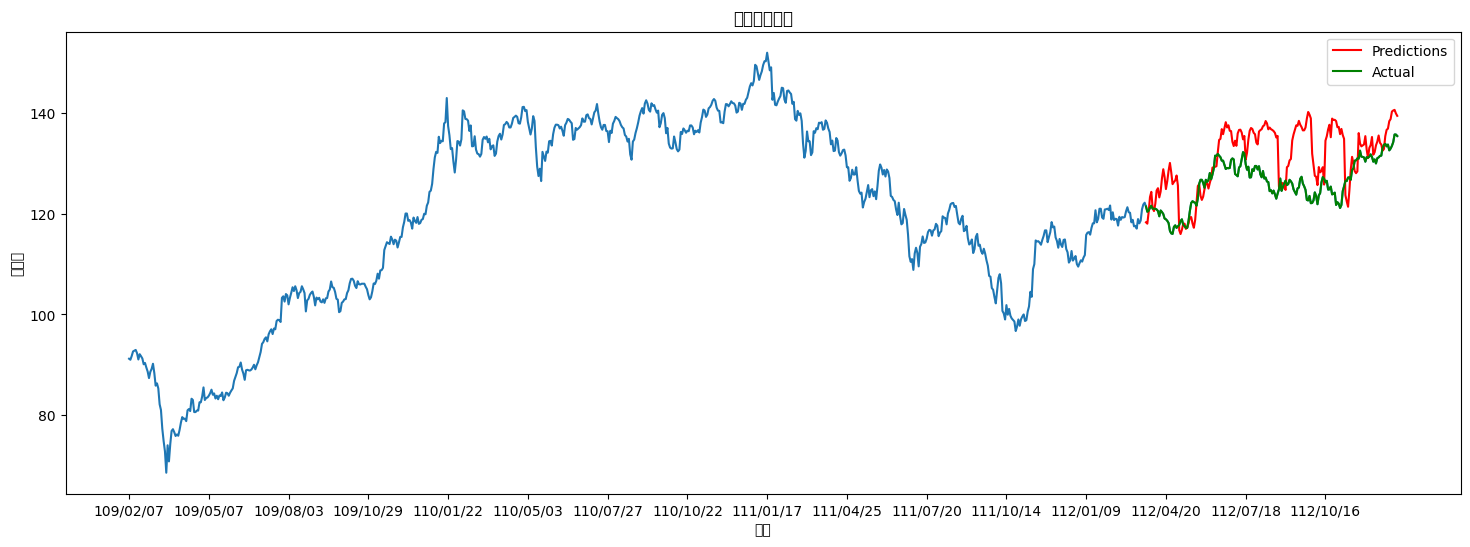

In [ ]:


df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
plt.figure(figsize=(18, 6))
plt.plot(df['日期'], df['收盤價'])
plt.xlabel('日期')
plt.ylabel('收盤價')
plt.title('收盤價走勢圖')

plt.xticks(df.get('日期')[::60],rotation=0)

# Calculate the correct starting index for plotting predictions
start_index = len(df) - len(test_result)

# Instead of test_dataset.__len__()*5, use the calculated start_index
plt.plot(df['日期'][start_index:], test_result, color='red', label='Predictions')
plt.plot(df['日期'][start_index:], df['收盤價'][start_index:], color='green', label='Actual')
plt.legend() # Add a legend to distinguish the lines
plt.show()

# Transformer模型

In [ ]:
input_dim = 10
nhead = 10
num_encoder_layers = 3
num_classes = 1

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # 创建一个形状为 (max_len, d_model) 的位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度使用 sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度使用 cos
        pe = pe.unsqueeze(0)  # 增加一个维度，形状变为 (1, max_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # 根据输入的序列长度裁剪位置编码
        x = x + self.pe[:, :seq_len, :]
        return x


In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, nhead, num_encoder_layers,num_classes, d_model=30):
        super(Transformer, self).__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model)

        # 确保输入经过映射到 d_model 维度
        self.input_fc = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        # 修改为符合输入特征维度的全连接层
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_fc(x)  # 映射到 d_model 维度
        x = self.positional_encoding(x)  # 加入位置编码
        x = x.permute(1, 0, 2)  # 转换为 (seq_len, batch_size, d_model)

        output = self.transformer_encoder(x)  # 经过 Transformer 编码器
        output = output[-1, :, :]  # 取序列最后一个时间步的输出
        output = self.fc(output)  # 输出层，回归值

        return output


In [ ]:
transformer = Transformer(input_dim=input_dim, nhead=nhead, num_encoder_layers=num_encoder_layers, num_classes=num_classes)
transformer

Transformer(
  (positional_encoding): PositionalEncoding()
  (input_fc): Linear(in_features=10, out_features=30, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=30, bias=True)
    (norm1): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
        )
        (linear1): Linea

## Train

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(transformer.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)

Transformer(
  (positional_encoding): PositionalEncoding()
  (input_fc): Linear(in_features=10, out_features=30, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=30, bias=True)
    (norm1): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
        )
        (linear1): Linea

In [ ]:
for epoch in range(800):
    transformer.train()
    for i, (seqs, labels) in enumerate(train_loader):
        seqs, labels = seqs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = transformer(seqs)

        loss = loss_fn(output, labels.squeeze())
        loss.backward()
        optimizer.step()


    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

Epoch: 100, Loss: 31.818363189697266
Epoch: 200, Loss: 6.67116117477417
Epoch: 300, Loss: 78.24693298339844
Epoch: 400, Loss: 3.299534320831299
Epoch: 500, Loss: 23.923433303833008
Epoch: 600, Loss: 9.232804298400879
Epoch: 700, Loss: 5.49852991104126
Epoch: 800, Loss: 4.8102641105651855


In [ ]:
output

tensor([[133.7324],
        [134.5817]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
transformer.eval()
total_loss = 0
test_result = []
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        output = transformer(seqs)
        test_result.extend(output.view(-1).detach().cpu().numpy())
        loss = loss_fn(output, labels.squeeze())
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Average Loss on Test Data: {avg_loss}")

Average Loss on Test Data: 32.03585171699524


In [ ]:
test_result

[119.69994,
 123.07239,
 120.33896,
 120.52992,
 121.11203,
 124.04157,
 121.10135,
 119.96984,
 119.26784,
 120.851295,
 123.13071,
 129.89615,
 121.75042,
 125.86354,
 138.82043,
 129.9039,
 130.61288,
 135.79453,
 134.60469,
 130.56412,
 129.03745,
 138.30412,
 133.58475,
 131.41835,
 132.88614,
 127.06841,
 131.80151,
 129.70459,
 125.08856,
 127.00468,
 132.0135,
 126.16935,
 135.69664,
 127.69976,
 141.83084,
 134.84612,
 135.04066,
 126.06569]

In [ ]:
test_dataset.labels.shape

array([[[118.65],
        [120.9 ],
        [121.85],
        [122.2 ],
        [121.45]],

       [[120.4 ],
        [120.6 ],
        [121.2 ],
        [121.6 ],
        [121.  ]],

       [[121.  ],
        [121.  ],
        [120.85],
        [120.55],
        [119.5 ]],

       [[120.65],
        [120.35],
        [119.95],
        [119.05],
        [118.9 ]],

       [[118.6 ],
        [118.15],
        [116.6 ],
        [116.1 ],
        [116.  ]],

       [[117.4 ],
        [117.7 ],
        [117.2 ],
        [117.5 ],
        [117.8 ]],

       [[118.55],
        [118.9 ],
        [117.8 ],
        [117.55],
        [117.2 ]],

       [[117.2 ],
        [118.6 ],
        [120.55],
        [122.15],
        [122.5 ]],

       [[122.3 ],
        [122.2 ],
        [121.6 ],
        [123.05],
        [125.95]],

       [[126.75],
        [126.75],
        [126.15],
        [125.15],
        [126.75]],

       [[126.35],
        [126.7 ],
        [128.1 ],
        [126.85],
        

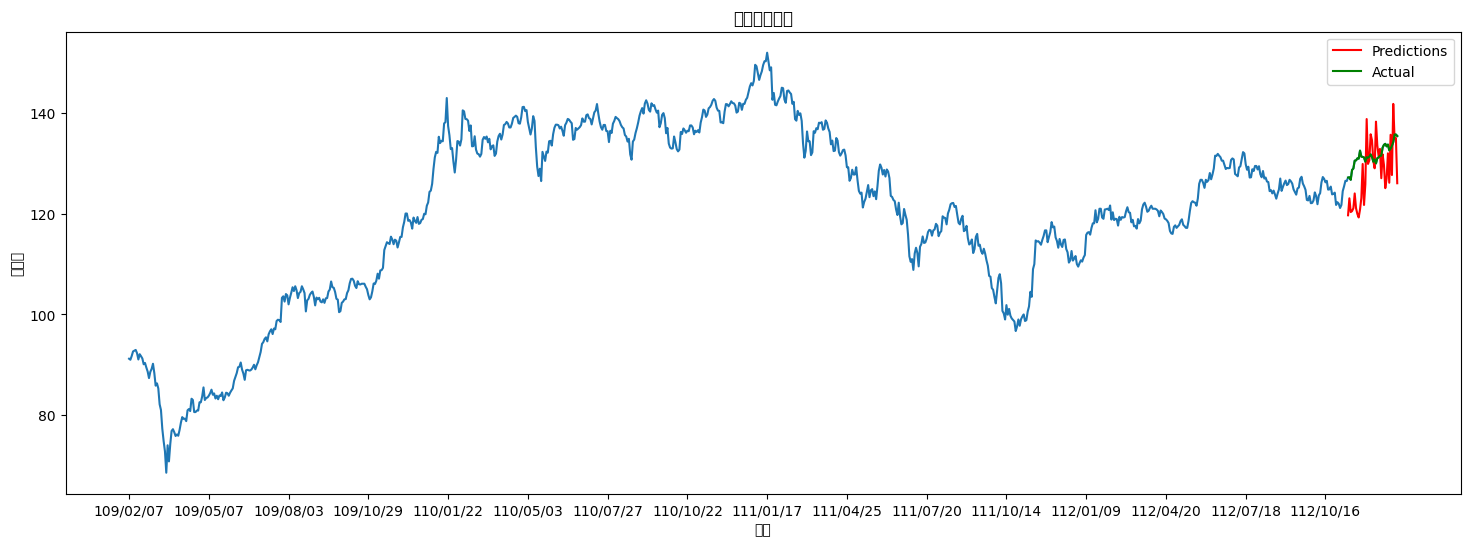

In [ ]:


df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
plt.figure(figsize=(18, 6))
plt.plot(df['日期'], df['收盤價'])
plt.xlabel('日期')
plt.ylabel('收盤價')
plt.title('收盤價走勢圖')

plt.xticks(df.get('日期')[::60],rotation=0)

# Calculate the correct starting index for plotting predictions
start_index = len(df) - len(test_result)

# Instead of test_dataset.__len__()*5, use the calculated start_index
plt.plot(df['日期'][start_index:], test_result, color='red', label='Predictions')
plt.plot(df['日期'][start_index:], df['收盤價'][start_index:], color='green', label='Actual')
plt.legend() # Add a legend to distinguish the lines
plt.show()